In [1]:
# %% Imports and Setup

# System and utility libraries
import os, gc, copy, random, shutil, sys
from collections import Counter

# Data manipulation and scientific computing
import numpy as np
import pandas as pd
from scipy.ndimage import gaussian_filter

# Plotting libraries
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

# Image processing
from skimage.transform import resize

# Scikit-learn: model selection and evaluation
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import (roc_auc_score, f1_score, precision_score, recall_score, accuracy_score,
                             confusion_matrix, ConfusionMatrixDisplay, classification_report,
                             mean_squared_error, mean_absolute_error)

# PyTorch and related libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.cuda.amp import GradScaler, autocast
from torch.utils.data import Dataset, DataLoader, random_split, Subset, ConcatDataset
from torchvision import transforms, models

!pip install lifelines
from lifelines.utils import concordance_index

# Install and import external packages quietly
!pip install einops --quiet
import einops
from einops import rearrange

!pip install SciencePlots --quiet
import scienceplots
plt.style.use(['science', 'grid'])
plt.rcParams['figure.dpi'] = 800
plt.rcParams['text.usetex'] = False # disable LaTeX because it is not available

SAVE_PATH = "/content/drive/MyDrive/"
# CUDA GPU acceleration if available
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Set random seed for reproducibility
random_seed = 42
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)

# Define test_ids from clinical-only ML approach
test_ids = ['35', '128', '34', '154', '174', '57', '114', '67', '51', '75', '93', '28', '118', '82', '117', '18', '36', '14', '89', '106', '83', '61', '48', '62', '161', '120']

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 20.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.7/115.7 kB 12.3 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4030 sha256=fb0f79be70a200517e2ff736b0d899c3b0e0c993298362bdd67d98ae710e9b39
  Stored in directory: /root/.cache/pip/wheels/8b/67/f4/2caaae2146198dcb824f31a303833b07b14a5ec863fb3acd7b
Successfully built autograd-gamma


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
test_path = f"/content/drive/MyDrive/PFS data /val_dataset_PFS_preprocessed.pt"
train_path = f"/content/drive/MyDrive/PFS data /train_dataset_PFS_preprocessed.pt"
dose_parameters = f"/content/drive/MyDrive/PFS data /PFS_filtered_data.csv"

sys.path.append('/content/drive/MyDrive/PFS data ')

# import model classes
from models_regression import CNNViT, SimpleCNN, ChannelSeparatedCNN, DepthwiseSeparable3DCNN, DepthwiseSeparable3DResNet


In [4]:
dataset_debug = False
# Load the datasets
if dataset_debug:
    train_data = torch.load(train_path, map_location='cpu')
    test_data = torch.load(test_path, map_location='cpu')

    # Filter duplicates based on patient_id
    seen_ids = set()
    filtered_data = []
    for sample in train_data + test_data:
        if sample['patient_id'] not in seen_ids:
            filtered_data.append(sample)
            seen_ids.add(sample['patient_id'])

    combined_data = filtered_data

    # Calculate statistics
    print("Dataset statistics:")
    print(f"Total number of unique patients: {len(combined_data)}")

    # Calculate PFS statistics
    pfs_months = [sample['pfs_months'] for sample in combined_data]
    pfs_events = [sample['pfs_event'] for sample in combined_data]

    print("\nPFS Statistics:")
    print(f"Median PFS: {np.median(pfs_months):.2f} months")
    print(f"Average PFS: {np.mean(pfs_months):.2f} months")
    print(f"Min PFS: {min(pfs_months):.2f} months")
    print(f"Max PFS: {max(pfs_months):.2f} months")

    # Event statistics
    n_events = sum(pfs_events)
    print("\nEvent Statistics:")
    print(f"Number of events: {n_events}")
    print(f"Number of censored: {len(pfs_events) - n_events}")
    print(f"Event rate: {(n_events/len(pfs_events))*100:.1f}%")

    # Image dimensions and clinical variables
    image_shape = combined_data[0]['image'].shape
    n_clinical = len(combined_data[0]['clinical_features'])
    print("\nDataset structure:")
    print(f"Image dimensions: {image_shape}")
    print(f"Number of clinical variables: {n_clinical}")

    # Split data based on test_ids
    test_data = [sample for sample in combined_data if sample['patient_id'] in test_ids]
    train_data = [sample for sample in combined_data if sample['patient_id'] not in test_ids]

    print("\nDataset splitting:")
    print(f"Training set: {len(train_data)} patients")
    print(f"Test set: {len(test_data)} patients")


In [ ]:
class GBMDataset3DLoaded(Dataset):
    def __init__(self,
                 data_list,
                 csv_path=dose_parameters,
                 is_train=True,
                 image_transform=None,
                 clinical_transform=None,
                 augmentation_transform=None):
        """
        Args:
            data_list (list): List of dictionaries including, for example:
                {
                    'image': 3D image (e.g. torch.Tensor or np.ndarray),
                    'pfs_months': progression-free survival in months,
                    'pfs_event': progression (1) or censored (0),
                    'patient_id': patient ID
                }
            csv_path (str): Path to the CSV file containing clinical data.
            is_train (bool): Indicates whether the dataset is used for training (controls, e.g., augmentation).
            image_transform (callable): Transformation applied to the image.
            clinical_transform (callable): Transformation applied to the clinical feature tensor.
            augmentation_transform (callable): Data augmentation (only when is_train=True).
        """
        self.data = data_list
        self.is_train = is_train
        self.image_transform = image_transform
        self.clinical_transform = clinical_transform
        self.augmentation_transform = augmentation_transform if is_train else None

        # 1. Read the CSV file with clinical data
        df = pd.read_csv(csv_path)

        # 2. Define numerical columns
        self.numerical_features = [
            'AgeAtStudyDate', 'Days_between_surgery_and_RT', 'prescription_dose',
            'num_fractions', 'max_dose', 'mean_dose', 'V95', 'V90', 'V50', 'V1',
            'brainstem_volume_cm3', 'brainstem_mean_dose', 'brainstem_max_dose'
        ]

        # 3. Define expected categories for manual one-hot encoding
        expected_categories = {
            'Sex': ["F", "M"],                   # Only valid values, no dummy for NaN
            'IDH1/2': ["negative", "positive", "NaN"],  # Include NaN as its own category
            'MGMT': ["negative", "positive", "NaN"]       # Include NaN as its own category
        }

        # 4. Clean up the original categorical columns:
        #    - Convert to strings, remove extra spaces, and replace different representations
        #      of missing values with "NaN"
        for col in expected_categories.keys():
            if col in df.columns:
                df[col] = df[col].astype(str).str.strip()
                df[col] = df[col].replace(["nan", "NaN", "None", "NULL", ""], "NaN")

        # 5. Manual one-hot encoding
        one_hot_columns = []
        for col, cats in expected_categories.items():
            for cat in cats:
                new_col = f"{col}_{cat}"
                # Set 1 if the original column's value equals the expected category, otherwise 0
                df[new_col] = (df[col] == cat).astype(np.float32)
                one_hot_columns.append(new_col)
        # Update the attribute with the names of the one-hot encoded columns
        self.categorical_features = one_hot_columns

        # 6. Remove the original categorical columns
        df.drop(columns=list(expected_categories.keys()), inplace=True)

        # 7. Fill missing values in the numerical columns with the column mean
        df[self.numerical_features] = df[self.numerical_features].fillna(
            df[self.numerical_features].mean()
        )

        # --- REPLACE -1 with the column mean computed from values that are not -1 ---
        for col in self.numerical_features:
            valid_mean = df.loc[df[col] != -1, col].mean()
            df.loc[df[col] == -1, col] = valid_mean

        # 8. Save the processed clinical data
        self.clinical_data = df

        # 9. Find all patient IDs in data_list for further calculation of mean/std
        all_patient_ids = [int(sample['patient_id'].item()) for sample in data_list]
        clinical_subset = self.clinical_data[self.clinical_data['patient_id'].isin(all_patient_ids)]
        if clinical_subset.empty:
            raise ValueError("No clinical data found for the specified patients.")

        # 10. Compute mean and std for the numerical features (for normalization)
        self.num_mean = torch.tensor(
            clinical_subset[self.numerical_features].mean().values.astype(np.float32)
        )
        self.num_std = torch.tensor(
            clinical_subset[self.numerical_features].std().values.astype(np.float32)
        )

        # 11. Check for missing clinical data for any patients
        data_patients = set(all_patient_ids)
        csv_patients = set(self.clinical_data['patient_id'])
        missing_patients = data_patients - csv_patients
        if missing_patients:
            print(f"Warning: Missing clinical data for patients: {missing_patients}")

    def __getitem__(self, idx):
        """
        Retrieves one sample from the dataset.
        """
        sample = self.data[idx]
        image = sample['image']
        patient_id = int(sample['patient_id'].item())

        # Find the corresponding row in the clinical data
        patient_clinical = self.clinical_data[self.clinical_data['patient_id'] == patient_id]
        if patient_clinical.empty:
            raise ValueError(f"No clinical data found for patient {patient_id}")
        patient_clinical = patient_clinical.iloc[0]

        # Extract numerical and categorical features
        numerical_vals = patient_clinical[self.numerical_features].values.astype(np.float32)
        categorical_vals = patient_clinical[self.categorical_features].values.astype(np.float32)

        # Construct PyTorch tensors
        numerical_tensor = torch.tensor(numerical_vals, dtype=torch.float32)
        categorical_tensor = torch.tensor(categorical_vals, dtype=torch.float32)

        # Combine categorical features first, then numerical features
        combined_features = torch.cat([categorical_tensor, numerical_tensor])

        # Retrieve pfs data (progression-free survival) from sample
        pfs_months = sample['pfs_months']
        pfs_event = sample['pfs_event']

        # Ensure the image is a torch.Tensor
        if not isinstance(image, torch.Tensor):
            if isinstance(image, np.ndarray):
                image = torch.from_numpy(image.copy())
            elif isinstance(image, (list, tuple)):
                image = torch.tensor(image, dtype=torch.float32)
            else:
                raise TypeError(f"Cannot convert image of type {type(image)} to torch.Tensor.")
        image = image.float().contiguous()

        # Apply data augmentation if provided
        if self.augmentation_transform:
            image = self.augmentation_transform(image)

        # Apply image transformations if provided
        if self.image_transform:
            image = self.image_transform(image)

        # Apply clinical feature transformations if provided
        if self.clinical_transform:
            combined_features = self.clinical_transform(combined_features)

        # Ensure that pfs_months and pfs_event are Tensor values
        if not isinstance(pfs_months, torch.Tensor):
            pfs_months = torch.tensor(pfs_months, dtype=torch.float32)
        else:
            pfs_months = pfs_months.clone().detach()

        if not isinstance(pfs_event, torch.Tensor):
            pfs_event = torch.tensor(pfs_event, dtype=torch.float32)
        else:
            pfs_event = pfs_event.clone().detach()

        return {
            'image': image,
            'clinical_features': combined_features,
            'patient_id': patient_id,
            'pfs_months': pfs_months,
            'pfs_event': pfs_event
        }

    def __len__(self):
        """
        Returns the number of samples in the dataset.
        """
        return len(self.data)


# --- Transformation Classes ---
class Normalize3D:
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        tensor = tensor.float()
        mean = self.mean.to(tensor.device).view(-1, 1, 1, 1)
        std = self.std.to(tensor.device).view(-1, 1, 1, 1)
        return (tensor - mean) / std

class NormalizeClinical:
    """
    Assumes that the combined clinical tensor is arranged such that the first elements are the
    categorical features and the last (num_numerical) elements are numerical.
    This transformation normalizes only the numerical features based on the training set mean and std.
    """
    def __init__(self, num_mean, num_std, num_numerical):
        self.num_mean = num_mean
        self.num_std = num_std
        self.num_numerical = num_numerical  # number of numerical features

    def __call__(self, clinical):
        clinical = clinical.float()
        cat_features = clinical[:-self.num_numerical]
        num_features = clinical[-self.num_numerical:]
        normalized_num = (num_features - self.num_mean) / self.num_std
        return torch.cat([cat_features, normalized_num])

class RandomFlip3D:
    def __init__(self, axes=(3,), p=0.5):
        self.axes = axes
        self.p = p

    def __call__(self, tensor):
        for axis in self.axes:
            if random.random() < self.p:
                tensor = torch.flip(tensor, dims=[axis])
        return tensor

class GaussianFilter3D:
    def __init__(self, sigma, channels):
        self.sigma = sigma
        self.channels = channels

    def __call__(self, tensor):
        tensor_np = tensor.numpy()
        for c in self.channels:
            tensor_np[c] = gaussian_filter(tensor_np[c], sigma=self.sigma)
        return torch.from_numpy(tensor_np)

class ReduceResolution3D:
    def __init__(self, scale_factor):
        self.scale_factor = scale_factor

    def __call__(self, tensor):
        tensor = torch.nn.functional.interpolate(
            tensor.unsqueeze(0),
            scale_factor=self.scale_factor,
            mode='trilinear',
            align_corners=False,
            recompute_scale_factor=True
        )
        return tensor.squeeze(0)

class Compose3D:
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, tensor):
        for t in self.transforms:
            tensor = t(tensor)
        return tensor

class SetDarkVoxelsToZero:
    def __init__(self, channels, threshold=0.1):
        self.channels = channels
        self.threshold = threshold

    def __call__(self, tensor):
        tensor_np = tensor.numpy()
        for c in self.channels:
            dark_voxels = tensor_np[c] < self.threshold
            tensor_np[c][dark_voxels] = 0
        return torch.from_numpy(tensor_np)


def compute_mean_std_two_pass(dataset):
    """
    Example function to calculate the mean and std for 3D images in the dataset.
    """
    loader = DataLoader(dataset, batch_size=10, shuffle=False, num_workers=0)
    first_sample = dataset[0]['image']
    n_channels = first_sample.shape[0]

    total_sum = torch.zeros(n_channels)
    total_pixels = 0

    for batch in loader:
        images = batch['image']
        B, C, D, H, W = images.shape
        total_sum += images.view(B, C, -1).sum(dim=(0, 2))
        total_pixels += B * D * H * W

    mean = total_sum / total_pixels

    total_var = torch.zeros(n_channels)
    loader = DataLoader(dataset, batch_size=10, shuffle=False, num_workers=0)
    for batch in loader:
        images = batch['image']
        B, C, D, H, W = images.shape
        diff = (images.view(B, C, -1) - mean.view(1, -1, 1)) ** 2
        total_var += diff.sum(dim=(0, 2))

    variance = total_var / total_pixels
    std = torch.sqrt(variance)
    std = torch.clamp(std, min=1e-6)
    return mean, std

def compute_clinical_mean_std_two_pass(dataset, num_numerical):
    """
    Example function to calculate the mean and std for clinical features in the dataset.
    """
    loader = DataLoader(dataset, batch_size=10, shuffle=False, num_workers=0)
    total_sum = torch.zeros(num_numerical)
    total_samples = 0

    for batch in loader:
        clinical = batch['clinical_features'][:, -num_numerical:]
        total_sum += clinical.sum(dim=0)
        total_samples += clinical.size(0)

    mean = total_sum / total_samples

    total_var = torch.zeros(num_numerical)
    loader = DataLoader(dataset, batch_size=10, shuffle=False, num_workers=0)
    for batch in loader:
        clinical = batch['clinical_features'][:, -num_numerical:]
        diff = (clinical - mean.unsqueeze(0)) ** 2
        total_var += diff.sum(dim=0)

    variance = total_var / total_samples
    std = torch.sqrt(variance)
    std = torch.clamp(std, min=1e-6)
    return mean, std

try:
    # Load the data
    train_data_list = torch.load(train_path, map_location='cpu', weights_only=False)
    test_data_list = torch.load(test_path, map_location='cpu', weights_only=False)

    # Combine training and test data
    combined_data_list = train_data_list + test_data_list
    print(f"Number of samples in combined_data_list: {len(combined_data_list)}")

    # Remove duplicates based on patient_id, if desired:
    seen_ids = set()
    unique_data_list = []
    for sample in combined_data_list:
        # Convert patient_id to string for comparison
        pid = str(sample['patient_id'].item() if isinstance(sample['patient_id'], torch.Tensor) else sample['patient_id'])
        if pid not in seen_ids:
            unique_data_list.append(sample)
            seen_ids.add(pid)
    combined_data_list = unique_data_list

    print(f"Number of unique samples after duplicate removal: {len(combined_data_list)}")

    # Split the data based on whether patient_id is in test_ids
    train_data_list = [
        sample for sample in combined_data_list
        if str(sample['patient_id'].item() if isinstance(sample['patient_id'], torch.Tensor) else sample['patient_id']) not in test_ids
    ]
    test_data_list = [
        sample for sample in combined_data_list
        if str(sample['patient_id'].item() if isinstance(sample['patient_id'], torch.Tensor) else sample['patient_id']) in test_ids
    ]

    print("Dataset splitting:")
    print(f"Training set: {len(train_data_list)} samples")
    print(f"Test set: {len(test_data_list)} samples")

    # Create a temporary dataset to calculate normalization statistics
    train_dataset_temp = GBMDataset3DLoaded(
        data_list=train_data_list,
        is_train=False,
        image_transform=None,
        clinical_transform=None,
        augmentation_transform=None
    )

    # Calculate statistics for images
    mean, std = compute_mean_std_two_pass(train_dataset_temp)
    print(f"Image Mean: {mean}")
    print(f"Image Std: {std}")

    # Calculate statistics for clinical features
    num_numerical = len(train_dataset_temp.numerical_features)
    clinical_mean, clinical_std = compute_clinical_mean_std_two_pass(train_dataset_temp, num_numerical)
    print(f"Clinical features (numerical) Mean: {clinical_mean}")
    print(f"Clinical features (numerical) Std: {clinical_std}")

    # Create normalization transformation objects (example)
    normalize_transform = Normalize3D(mean=mean, std=std)
    clinical_normalization_transform = NormalizeClinical(
        num_mean=clinical_mean,
        num_std=clinical_std,
        num_numerical=num_numerical
    )

    # Example composite image transformations
    image_transform_list = [
        GaussianFilter3D(sigma=1, channels=[0, 1, 2])
    ]
    image_transform = Compose3D(image_transform_list)

    #data augmentation
    augmentation_transform = RandomFlip3D(axes=(3,), p=1)

    # Create training and test datasets
    train_dataset_augmented = GBMDataset3DLoaded(
        data_list=train_data_list,
        is_train=True,
        image_transform=image_transform,
        clinical_transform=clinical_normalization_transform,
        augmentation_transform=augmentation_transform
    )

    train_dataset_non_augmented = GBMDataset3DLoaded(
        data_list=train_data_list,
        is_train=True,
        image_transform=image_transform,
        clinical_transform=clinical_normalization_transform,
        augmentation_transform=None
    )

    test_dataset = GBMDataset3DLoaded(
        data_list=test_data_list,
        is_train=False,
        image_transform=image_transform,
        clinical_transform=clinical_normalization_transform,
        augmentation_transform=None
    )

    print(f"Training dataset with augmentation size: {len(train_dataset_augmented)}")
    print(f"Training dataset without augmentation size: {len(train_dataset_non_augmented)}")
    print(f"Test dataset size: {len(test_dataset)}")

    # Create DataLoaders for training and test sets
    train_loader_augmented = DataLoader(train_dataset_augmented, batch_size=4, shuffle=True, num_workers=4)
    train_loader_non_augmented = DataLoader(train_dataset_non_augmented, batch_size=4, shuffle=False, num_workers=4)
    test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=4)

except FileNotFoundError as e:
    print(f"Error loading data: {e}")
    raise e


Number of samples in combined_data_list: 178
Number of unique samples after duplicate removal: 156
Dataset splitting:
Training set: 133 samples
Test set: 23 samples


<ipython-input-5-440b10ed30c8>:77: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '38.29775280898876' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[df[col] == -1, col] = valid_mean
<ipython-input-5-440b10ed30c8>:77: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '27.117977528089888' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[df[col] == -1, col] = valid_mean


Image Mean: tensor([-4.5753e-08, -1.8933e-08, -2.9533e-09])
Image Std: tensor([1., 1., 1.])
Clinical features (numerical) Mean: tensor([5.4699e+01, 3.7248e+01, 5.8880e+01, 2.6977e+01, 6.0286e+01, 2.3768e+00,
        1.3029e+02, 2.6463e+02, 5.3309e+02, 4.1025e+03, 3.9319e+01, 2.0352e+01,
        5.1375e+01])
Clinical features (numerical) Std: tensor([ 13.0890,  37.3563,   3.8520,   7.2126,  14.7389,   0.8397,  76.0653,
         96.3087, 161.9644, 820.0345,  16.1785,   9.2936,  16.9678])
Training dataset with augmentation size: 133
Training dataset without augmentation size: 133
Test dataset size: 23


<ipython-input-5-440b10ed30c8>:77: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '38.29775280898876' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[df[col] == -1, col] = valid_mean
<ipython-input-5-440b10ed30c8>:77: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '27.117977528089888' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[df[col] == -1, col] = valid_mean
<ipython-input-5-440b10ed30c8>:77: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '38.29775280898876' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[df[col] == -1, col] = valid_mean
<ipython-input-5-440b10ed30c8>:77: FutureWarning: Setting an it

In [6]:
# --- 1. Look at a few samples ---
print("Showing clinical_features from first 3 samples:")
for i in range(3):
    sample = train_dataset_augmented[i]
    clinical = sample["clinical_features"]
    print(f"Sample {i} -> shape: {clinical.shape} -> values:\n{clinical}\n")

# --- 2. Compute overall mean/std across the dataset ---
all_clinical = []
for i in range(len(train_dataset_augmented)):
    sample = train_dataset_augmented[i]
    # Each clinical_features is a 1D tensor: [num_categorical + num_numerical]
    all_clinical.append(sample["clinical_features"].numpy())

all_clinical = np.stack(all_clinical, axis=0)  # Shape: (N, num_feats)
cat_part = all_clinical[:, :-num_numerical]  # The first part is categorical
num_part = all_clinical[:, -num_numerical:]  # The last part is numerical

cat_unique_values = [np.unique(cat_part[:, c]) for c in range(cat_part.shape[1])]
num_mean = num_part.mean(axis=0)
num_std  = num_part.std(axis=0)

print("Unique categorical values in training set:")
for c_idx, unique_vals in enumerate(cat_unique_values):
    print(f"  Categorical column {c_idx}: {unique_vals}")

print("\nMean of numerical features across the entire train_dataset_augmented:")
print(num_mean)

print("\nStd of numerical features across the entire train_dataset_augmented:")
print(num_std)

Showing clinical_features from first 3 samples:
Sample 0 -> shape: torch.Size([21]) -> values:
tensor([ 1.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000,
         1.0162,  1.4389, -0.0314,  0.5577,  0.4187,  1.4874, -0.6925, -0.2893,
         0.0081, -0.9666, -0.7404,  0.8499,  0.5003])

Sample 1 -> shape: torch.Size([21]) -> values:
tensor([ 0.0000,  1.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000,
        -1.7342, -0.5688, -0.0314, -0.2742,  0.0412,  1.1102, -0.0960,  0.2044,
         1.1066, -0.0411, -0.4663,  2.3728,  0.3669])

Sample 2 -> shape: torch.Size([21]) -> values:
tensor([ 1.0000,  0.0000,  0.0000,  0.0000,  1.0000,  1.0000,  0.0000,  0.0000,
        -3.5678,  0.2878, -0.0314, -3.0471, -3.3726, -2.3824, -0.7281, -0.8477,
        -0.9024, -1.4812, -0.8849, -1.9371, -2.7507])

Unique categorical values in training set:
  Categorical column 0: [0. 1.]
  Categorical column 1: [0. 1.]
  Categorical column 2: [0. 1.]
  Categorical column 3: [0.

In [ ]:
def compute_normalized_clinical_stats(dataset, num_numerical):
    loader = DataLoader(dataset, batch_size=10, shuffle=False, num_workers=0)
    all_num = []
    for batch in loader:
        clinical = batch['clinical_features']
        num_features = clinical[:, -num_numerical:]
        all_num.append(num_features)
    all_num = torch.cat(all_num, dim=0)
    mean = all_num.mean(dim=0)
    std = all_num.std(dim=0)
    return mean, std

norm_mean, norm_std = compute_normalized_clinical_stats(train_dataset_augmented, num_numerical)
print("Normalized numerical mean:", norm_mean)
print("Normalized numerical std:", norm_std)

def check_nan_in_clinical(dataset):
    loader = DataLoader(dataset, batch_size=10, shuffle=False, num_workers=0)
    total_nan = 0
    for i, batch in enumerate(loader):
        clinical = batch['clinical_features']
        # Count the number of NaNs in the combined clinical tensor
        n_nan = torch.isnan(clinical).sum().item()
        total_nan += n_nan
        if n_nan > 0:
            print(f"Batch {i} has {n_nan} NaN values in clinical_features.")
    if total_nan == 0:
        print("No NaN values found in clinical_features.")
    else:
        print(f"Total number of NaN values in clinical_features: {total_nan}")

# Debug: check if there are NaN values in the data
# check_nan_in_clinical(train_dataset_non_augmented)


Normalized numerical mean: tensor([-8.6046e-08,  3.5852e-08, -4.7325e-07,  1.7030e-08, -3.8990e-07,
         4.0155e-07, -1.0576e-07,  3.9438e-08,  5.0193e-08,  7.1705e-07,
        -3.0743e-07, -1.7926e-07,  4.5174e-07])
Normalized numerical std: tensor([1.0038, 1.0038, 1.0038, 1.0038, 1.0038, 1.0038, 1.0038, 1.0038, 1.0038,
        1.0038, 1.0038, 1.0038, 1.0038])


## Model definitions

In [ ]:
# -------------------------------
 #Factory Function for CNNViT Regression Model
# -------------------------------
def cnn_vit_model(output_dim=1, clinical_dim=21):
    """
    Returns an instance of the CNNViT model for regression.
    """
    return CNNViT(output_dim=output_dim, clinical_dim=clinical_dim)

In [ ]:

def simple_cnn_model(input_shape=(3, 100, 256, 256), clinical_dim=21):
    """
    Factory function to create a SimpleCNN instance.

    Args:
        input_shape (tuple): (3, 100, 256, 256).
        clinical_dim (int): The dimension of the clinical data.
    """
    model = SimpleCNN(input_shape=input_shape, clinical_dim=clinical_dim)
    model.initialize_weights()
    return model

In [ ]:
def channel_separated_cnn_model(in_channels=3, clinical_dim=21):
    """
    Factory function to create a ChannelSeparatedCNN model and initialize weights.
    """
    model = ChannelSeparatedCNN(in_channels=in_channels, clinical_dim=clinical_dim)
    model.initialize_weights()
    return model

In [ ]:
def depthwise_separable_3dcnn_model(clinical_dim=15, input_shape=(100, 256, 256)):
    model = DepthwiseSeparable3DCNN(clinical_dim=clinical_dim, input_shape=input_shape)
    model.initialize_weights()
    return model

In [ ]:

def depthwise_separable_3dresnet_model(clinical_dim=15, input_shape=(100, 256, 256)):
    model = DepthwiseSeparable3DResNet(clinical_dim=clinical_dim,
                                       input_shape=input_shape)
    return model

## Training functions

In [ ]:
# -----------------------------
# Custom Loss Functions
# -----------------------------
def custom_mse_loss(pred, target, event, reduction='mean'):
    """
    Standard MSE loss with one-sided adjustment for censored patients.
    For event==1: loss = (target - pred)^2
    For event==0: loss = (max(0, target - pred))^2
    """
    pred = pred.view(-1)
    target = target.view(-1)
    diff = target - pred  # positive when prediction is under the observed time
    loss = torch.where(event.view(-1) == 0, torch.clamp(diff, min=0)**2, diff**2)
    if reduction == 'mean':
        return loss.mean()
    elif reduction == 'sum':
        return loss.sum()
    else:
        return loss

def weighted_custom_mse_loss(pred, target, event, global_mean, global_std, reduction='mean'):
    """
    Weighted MSE loss with one-sided adjustment for censored patients.
    Each datapoint is weighted as:
         w = 1 + |target - global_mean| / global_std
    """
    pred = pred.view(-1)
    target = target.view(-1)
    event  = event.view(-1)
    diff = target - pred
    residual = torch.where(event == 0, torch.clamp(diff, min=0.0), diff)

    # Convert global_mean and global_std to tensors if necessary.
    if isinstance(global_mean, float):
        global_mean = torch.tensor(global_mean, device=target.device, dtype=torch.float32)
    if isinstance(global_std, float):
        global_std = torch.tensor(global_std, device=target.device, dtype=torch.float32)
    if global_std.item() == 0:
        global_std = torch.tensor(1.0, device=target.device)

    weights = 1.0 + torch.abs(target - global_mean) / global_std
    loss = weights * (residual ** 2)

    if reduction == 'mean':
        return loss.sum() / weights.sum()
    elif reduction == 'sum':
        return loss.sum()
    else:
        return loss

# -----------------------------
# Negative Log Likelihood Loss (Cox Partial Likelihood)
# -----------------------------
def negative_log_likelihood_loss(pred, target, event):
    """
    Compute the negative log likelihood loss based on the Cox partial likelihood.
    For each patient with an event (event==1), the loss is:
         loss = - (pred[i] - log(sum_{j in risk set of i} exp(pred[j])))
    where the risk set for patient i includes all patients with survival time >= target[i].
    The loss is averaged over the number of events.
    """
    pred = pred.view(-1)
    target = target.view(-1)
    event = event.view(-1)

    # Sort patients in descending order of survival time so that
    # the risk set for patient i includes all patients from i to end.
    order = torch.argsort(target, descending=True)
    pred = pred[order]
    target = target[order]
    event = event[order]

    exp_pred = torch.exp(pred)
    # For each patient, the risk set sum is the cumulative sum from the current index to the end.
    risk_set_sum = torch.cumsum(exp_pred, dim=0)

    eps = 1e-8  # to prevent log(0)
    # For patients with an event, the loss contribution is:

    loss = -(pred - torch.log(risk_set_sum + eps)) * event
    # Average over the total number of events (with eps to avoid division by zero)
    loss = loss.sum() / (event.sum() + eps)
    return loss

# -----------------------------
# Training and Validation Function
# -----------------------------
def train_and_validate(model_class,
                       model_name,
                       learning_rate,
                       train_loader,
                       val_loader,
                       device,
                       clinical_dim=15,
                       num_epochs=50,
                       accumulation_steps=1,
                       early_stopping_patience=15,
                       use_mixed_precision=True,
                       loss_type="mse",  # Options: "mse", "cindex", "combined"
                       weighted_mse=False,    # If True and loss_type=="mse" or "combined", use weighted MSE loss
                       train_global_mean=None,  # If None, computed from training data
                       train_global_std=None,
                       ranking_loss_weight=0.0):  # Used only if loss_type=="combined"
    """
    Train and validate a model that outputs regression predictions.
    The training loss can be:
      - MSE (or weighted MSE),
      - Negative Log Likelihood (as a surrogate for the c-index),
      - Or a combination of both.
    """
    # Define your model factory. Ensure these functions are defined/imported.
    model_factory = {
        'CNNViT': cnn_vit_model,
        'SimpleCNN': simple_cnn_model,
        'ChannelSeparatedCNN': channel_separated_cnn_model,
        'DepthwiseSeparable3DCNN': depthwise_separable_3dcnn_model,
        'DepthwiseSeparable3DResNet': depthwise_separable_3dresnet_model
    }

    if model_class not in model_factory:
        raise ValueError(f"Unknown model class: {model_class}")

    try:
        model = model_factory[model_class](clinical_dim=clinical_dim).to(device)
        print(f"Initialized model: {model_class}")
    except Exception as e:
        print(f"Error initializing model {model_class}: {e}")
        raise e

    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
    scaler = torch.amp.GradScaler() if use_mixed_precision and device.startswith("cuda") else None

    # Compute global mean/std for weighted MSE from training data if needed.
    if weighted_mse and (train_global_mean is None or train_global_std is None):
        pfs_list = []
        for batch in train_loader:
            pfs_list.append(batch['pfs_months'].cpu().numpy())
        pfs_all = np.concatenate(pfs_list)
        train_global_mean = np.mean(pfs_all)
        train_global_std = np.std(pfs_all)
        print(f"Computed weighted MSE parameters: mean = {train_global_mean:.4f}, std = {train_global_std:.4f}")

    best_val_loss = float('inf')
    best_train_loss = float('inf')
    best_model_state = None
    best_model_path = None
    epochs_no_improve = 0
    training_success = True

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        total_samples = 0
        optimizer.zero_grad()
        accumulated_steps = 0

        for i, batch in enumerate(train_loader):
            pfs_months    = batch['pfs_months'].float().to(device)
            pfs_event     = batch['pfs_event'].float().to(device)
            clinical_data = batch['clinical_features'].float().to(device)
            dose_images   = batch['image'].to(device)

            with autocast(enabled=(use_mixed_precision and device.startswith('cuda'))):
                outputs = model(dose_images, clinical_data)
                # Use the regression output (if model outputs multiple values, take the first)
                reg_outputs = outputs[0] if isinstance(outputs, (tuple, list)) else outputs

                # Choose loss type.
                if loss_type == "mse":
                    if weighted_mse:
                        loss_value = weighted_custom_mse_loss(reg_outputs, pfs_months, pfs_event,
                                                                train_global_mean, train_global_std)
                    else:
                        loss_value = custom_mse_loss(reg_outputs, pfs_months, pfs_event)
                elif loss_type == "cindex":
                    loss_value = negative_log_likelihood_loss(reg_outputs, pfs_months, pfs_event)
                elif loss_type == "combined":
                    if weighted_mse:
                        mse_loss = weighted_custom_mse_loss(reg_outputs, pfs_months, pfs_event,
                                                            train_global_mean, train_global_std)
                    else:
                        mse_loss = custom_mse_loss(reg_outputs, pfs_months, pfs_event)
                    r_loss = negative_log_likelihood_loss(reg_outputs, pfs_months, pfs_event)
                    # You can adjust the weighting between mse and nll loss.
                    loss_value = 0.5 * mse_loss + 0.5 * r_loss
                else:
                    raise ValueError(f"Unknown loss_type: {loss_type}")

                loss = loss_value / accumulation_steps

            if scaler is not None:
                scaler.scale(loss).backward()
            else:
                loss.backward()

            accumulated_steps += 1
            total_samples += pfs_months.size(0)
            running_loss += loss_value.item() * pfs_months.size(0)

            if accumulated_steps == accumulation_steps:
                if scaler is not None:
                    scaler.step(optimizer)
                    scaler.update()
                else:
                    optimizer.step()
                optimizer.zero_grad()
                accumulated_steps = 0

        if accumulated_steps != 0:
            if scaler is not None:
                scaler.step(optimizer)
                scaler.update()
            else:
                optimizer.step()
            optimizer.zero_grad()

        train_loss = running_loss / total_samples if total_samples > 0 else 0.0

        # --- Validation Phase ---
        val_loss = float('inf')
        c_index = None
        if val_loader is not None:
            val_loss, c_index = validate(model, val_loader, device, use_mixed_precision,
                                         loss_type, weighted_mse, train_global_mean, train_global_std)
            scheduler.step(val_loss)
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_train_loss = train_loss
                best_model_state = model.state_dict()
                if best_model_path and os.path.exists(best_model_path):
                    os.remove(best_model_path)
                best_model_path = f'best_{model_name}_lr_{learning_rate}_epoch_{epoch+1}.pth'
                torch.save(best_model_state, best_model_path)
                epochs_no_improve = 0
            else:
                epochs_no_improve += 1

            print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | c-index: {c_index:.4f}")
            if epochs_no_improve >= early_stopping_patience:
                print(f"Early stopping triggered after {epoch+1} epochs.")
                break
        else:
            print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f}")

    return {
        'Model': model_name,
        'Learning Rate': learning_rate,
        'Best Val Loss': best_val_loss,
        'Best Train Loss': best_train_loss,
        'Best Model Path': best_model_path,
        'c_index': c_index,
        'success': training_success
    }

# -----------------------------
# Helper Function for Validation
# -----------------------------
def validate(model, dataloader, device, use_mixed_precision=True,
             loss_type="mse", weighted_mse=False, train_global_mean=None, train_global_std=None):
    """
    Validate the model. Computes the average loss over the validation set and calculates the c-index.
    """
    model.eval()
    val_loss = 0.0
    total_samples = 0

    # For concordance index calculation.
    predictions_list = []
    times_list = []
    events_list = []

    with torch.no_grad():
        for batch in dataloader:
            pfs_months  = batch['pfs_months'].float().to(device)
            pfs_event   = batch['pfs_event'].float().to(device)
            clinical_data = batch['clinical_features'].float().to(device)
            dose_images = batch['image'].to(device)

            with autocast(enabled=(use_mixed_precision and device.startswith('cuda'))):
                outputs = model(dose_images, clinical_data)
                reg_outputs = outputs[0] if isinstance(outputs, (tuple, list)) else outputs

                if loss_type == "mse":
                    if weighted_mse:
                        loss_value = weighted_custom_mse_loss(reg_outputs, pfs_months, pfs_event,
                                                              train_global_mean, train_global_std)
                    else:
                        loss_value = custom_mse_loss(reg_outputs, pfs_months, pfs_event)
                elif loss_type == "cindex":
                    loss_value = negative_log_likelihood_loss(reg_outputs, pfs_months, pfs_event)
                elif loss_type == "combined":
                    if weighted_mse:
                        mse_loss = weighted_custom_mse_loss(reg_outputs, pfs_months, pfs_event,
                                                            train_global_mean, train_global_std)
                    else:
                        mse_loss = custom_mse_loss(reg_outputs, pfs_months, pfs_event)
                    r_loss = negative_log_likelihood_loss(reg_outputs, pfs_months, pfs_event)
                    loss_value = 0.5 * mse_loss + 0.5 * r_loss
                else:
                    raise ValueError(f"Unknown loss_type: {loss_type}")

            batch_size = pfs_months.size(0)
            val_loss += loss_value.item() * batch_size
            total_samples += batch_size

            # Collect predictions for c-index.
            predictions_list.extend(reg_outputs.cpu().numpy().flatten())
            times_list.extend(pfs_months.cpu().numpy().flatten())
            events_list.extend(pfs_event.cpu().numpy().flatten())

    avg_loss = val_loss / total_samples if total_samples > 0 else 0.0
    # Compute concordance index.
    # We pass negative predictions since a higher predicted survival time implies a lower risk.
    c_index = concordance_index(np.array(times_list), -np.array(predictions_list), np.array(events_list))
    print(f"Validation Loss: {avg_loss:.4f} | c-index: {c_index:.4f}")
    return avg_loss, c_index

In [ ]:
import shutil

model_classes = ['DepthwiseSeparable3DResNet', 'CNNViT', 'DepthwiseSeparable3DCNN', 'ChannelSeparatedCNN']

learning_rates = [1e-4, 1e-5]
train_flag = True

batch_size_mapping = {
    'CNNViT': 2,
    'DepthwiseSeparable3DCNN': 2,
    'ChannelSeparatedCNN': 4,
    'DepthwiseSeparable3DResNet': 2,
}

train_val_results = []
all_fold_results = []

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Training parameters
num_epochs = 50
accumulation_steps = 8
early_stopping_patience = 10
clinical_dim = 21
max_retries = 3
n_splits = 5

# Where to save best model and outputs
SAVE_PATH = '/content/drive/MyDrive/'
best_model_filename = 'best_model.pth'
best_model_path = os.path.join(SAVE_PATH, best_model_filename)

# --- Prepare data for k-fold (assumes train_dataset_non_augmented exists) ---
pfs_values = np.array([sample['pfs_months'] for sample in train_dataset_non_augmented])
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Global trackers
global_best_val_loss = float('inf')
global_best_model_class = None

# ---------------------------
#        Training loop
# ---------------------------
if train_flag:
    for model_class in model_classes:
        batch_size = batch_size_mapping.get(model_class, 4)

        for lr in learning_rates:
            fold_results = []
            for fold, (train_idx, val_idx) in enumerate(kf.split(pfs_values), start=1):
                print(f'\n--- Training {model_class} with LR={lr}, Fold {fold}/{n_splits} ---')

                # create subsets
                fold_train = Subset(train_dataset_augmented, train_idx) + Subset(train_dataset_non_augmented, train_idx)
                fold_val = Subset(train_dataset_non_augmented, val_idx)

                train_loader = DataLoader(fold_train, batch_size=batch_size,
                                          shuffle=True, num_workers=4, pin_memory=True, drop_last=True)
                val_loader   = DataLoader(fold_val,   batch_size=batch_size,
                                          shuffle=False, num_workers=4, pin_memory=True, drop_last=True)

                attempt = 0
                success = False
                while attempt < max_retries and not success:
                    result = train_and_validate(
                        model_class=model_class,
                        model_name=model_class,
                        learning_rate=lr,
                        train_loader=train_loader,
                        val_loader=val_loader,
                        device=device,
                        num_epochs=num_epochs,
                        accumulation_steps=accumulation_steps,
                        early_stopping_patience=early_stopping_patience,
                        use_mixed_precision=True,
                        clinical_dim=clinical_dim,
                        loss_type="mse"
                    )

                    if result.get('success', False):
                        success = True
                        print(f"Training succeeded on attempt {attempt+1}")
                        result.update({
                            'Model Class': model_class,
                            'Learning Rate': lr,
                            'Batch Size': batch_size,
                            'Fold': fold
                        })
                        fold_results.append(result)
                        all_fold_results.append(result)

                        current_val_loss = result['Best Val Loss']
                        src_path = result['Best Model Path']

                        if current_val_loss < global_best_val_loss:
                            # remove old best
                            if os.path.exists(best_model_path):
                                os.remove(best_model_path)
                                print(f"Deleted previous best model: {best_model_path}")

                            # atomic move via temp file
                            tmp_path = best_model_path + '.tmp'
                            shutil.move(src_path, tmp_path)
                            os.replace(tmp_path, best_model_path)
                            print(f"New best model saved at: {best_model_path}")

                            global_best_val_loss = current_val_loss
                            global_best_model_class = model_class
                            result['Best Model Path'] = best_model_path
                        else:
                            # clean up non-best checkpoint
                            if os.path.exists(src_path):
                                os.remove(src_path)
                                print(f"Deleted non-optimal model file: {src_path}")
                    else:
                        attempt += 1
                        print(f"Training failed on attempt {attempt}. Retrying...")

                if device == 'cuda':
                    torch.cuda.empty_cache()

            # after folds, log averages
            if fold_results:
                avg_val = np.mean([r['Best Val Loss'] for r in fold_results])
                avg_train = np.mean([r['Best Train Loss'] for r in fold_results])
                print(f"Avg val loss for {model_class}, LR={lr}: {avg_val:.4f}")
                print(f"Avg train loss for {model_class}, LR={lr}: {avg_train:.4f}")

                train_val_results.append({
                    'Model': model_class,
                    'Learning Rate': lr,
                    'Average Val Loss': avg_val,
                    'Average Train Loss': avg_train,
                    'success': True
                })

    # summary of best
    if global_best_val_loss < float('inf'):
        print("\nBest Model Found:")
        print(f"Class: {global_best_model_class}")
        print(f"Val Loss: {global_best_val_loss:.4f}")
        print(f"Path: {best_model_path}")
    else:
        print("No successful model was trained.")

# --- Save & plot aggregate results ---
if train_val_results:
    df_results = pd.DataFrame(train_val_results)
    out_csv = os.path.join(SAVE_PATH, 'Training_resultsPFS_MSE.csv')
    df_results.to_csv(out_csv, index=False)
    print(f"Wrote summary CSV to {out_csv}")

    df_results['Label'] = df_results.apply(lambda r: f"{r['Model']}\nLR={r['Learning Rate']}", axis=1)
    plt.figure(figsize=(10, 6))
    plt.bar(df_results['Label'], df_results['Average Val Loss'])
    plt.xlabel("Model (Learning Rate)")
    plt.ylabel("Avg. validation loss")
    plt.title("Avg. Validation loss for each model")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    fig_path = os.path.join(SAVE_PATH, 'Training_loss_figure.pdf')
    plt.savefig(fig_path)
    plt.show()
    print(f"Saved plot to {fig_path}")

In [20]:
# Combine training and validation datasets for fine tuning
combined_dataset = ConcatDataset([train_dataset_augmented, train_dataset_non_augmented])
global_best_model_class = 'CNNViT'

TRAIN_C_INDEX = False

# Step 1: Split patients based on patient ids in non-augmented dataset
non_augmented_patient_ids = list({sample['patient_id'] for sample in train_dataset_non_augmented})
np.random.shuffle(non_augmented_patient_ids)

# Define 80/20 split based on patients
split_idx = int(np.floor(0.8 * len(non_augmented_patient_ids)))
train_patient_ids = set(non_augmented_patient_ids[:split_idx])
val_patient_ids   = set(non_augmented_patient_ids[split_idx:])

# Step 2: Build the training subset from the combined dataset
tune_train_idx = [
    i for i, sample in enumerate(combined_dataset)
    if sample['patient_id'] in train_patient_ids
]

# Step 3: For validation, use non-augmented samples and ensure one sample per patient
tune_val_idx = []
for patient in val_patient_ids:
    for i, sample in enumerate(train_dataset_non_augmented):
        if sample['patient_id'] == patient:
            tune_val_idx.append(i)
            break

# Step 4: Create Subset objects
tune_train_subset = Subset(combined_dataset, tune_train_idx)
tune_val_subset   = Subset(train_dataset_non_augmented, tune_val_idx)

# Hyperparameter grids
fine_tune_learning_rates    = [1e-3]
fine_tune_batch_sizes       = [2]
fine_tune_accumulation_steps = [1, 8]
tune_num_epochs             = 100
tune_early_stopping_patience = 15

# Use c-index as metric
loss_type       = "cindex"
use_cindex      = (loss_type == "cindex")
best_tune_metric = -float('inf') if use_cindex else float('inf')
best_tuned_model_path = os.path.join(SAVE_PATH, 'best_tuned_model.pth')
best_tune_hyperparams  = {}
fine_tune_results      = []

# Fine-tuning loop
for accum_steps in fine_tune_accumulation_steps & TRAIN_C_INDEX:
    for ft_lr in fine_tune_learning_rates:
        for ft_bs in fine_tune_batch_sizes:
            print(f"\n--- Fine Tuning with LR={ft_lr}, BS={ft_bs}, AccSteps={accum_steps} ---")

            # DataLoaders
            tune_train_loader = DataLoader(
                tune_train_subset,
                batch_size=ft_bs,
                shuffle=True,
                num_workers=4,
                pin_memory=True,
                drop_last=True
            )
            tune_val_loader = DataLoader(
                tune_val_subset,
                batch_size=ft_bs,
                shuffle=False,
                num_workers=4,
                pin_memory=True,
                drop_last=True
            )

            # Train & validate
            result = train_and_validate(
                model_class=global_best_model_class,
                model_name=global_best_model_class,
                learning_rate=ft_lr,
                train_loader=tune_train_loader,
                val_loader=tune_val_loader,
                device=device,
                clinical_dim=clinical_dim,
                num_epochs=tune_num_epochs,
                accumulation_steps=accum_steps,
                early_stopping_patience=tune_early_stopping_patience,
                use_mixed_precision=True,
                loss_type=loss_type
            )

            # Extract metric
            current_metric = result['c_index'] if use_cindex else result['Best Val Loss']
            fine_tune_results.append({
                'learning_rate':      ft_lr,
                'batch_size':         ft_bs,
                'accumulation_steps': accum_steps,
                'metric':             current_metric
            })

            # Check for new best
            is_better = (use_cindex and current_metric > best_tune_metric) or \
                        (not use_cindex and current_metric < best_tune_metric)
            if is_better:
                best_tune_metric = current_metric
                best_tune_hyperparams = {
                    'learning_rate':      ft_lr,
                    'batch_size':         ft_bs,
                    'accumulation_steps': accum_steps
                }
                # Remove old best if exists
                if os.path.exists(best_tuned_model_path):
                    os.remove(best_tuned_model_path)
                # Move new best across filesystems
                shutil.move(result['Best Model Path'], best_tuned_model_path)
                if use_cindex:
                    print(f"New best model! c-index = {current_metric:.4f}")
                else:
                    print(f"New best model! Val Loss = {current_metric:.4f}")
            else:
                # Clean up this run’s checkpoint
                if os.path.exists(result['Best Model Path']):
                    os.remove(result['Best Model Path'])

# Summary
if fine_tune_results:
  print("\n--- Fine Tuning Completed ---")
  if use_cindex:
      print(f"Best Fine-Tuned c-index: {best_tune_metric:.4f}")
  else:
      print(f"Best Fine-Tuned Val Loss: {best_tune_metric:.4f}")
  print("Best Hyperparams:", best_tune_hyperparams)
  print("Best Model saved at:", best_tuned_model_path)

  # -----------------------------
  # Visualize Fine Tuning Results
  # -----------------------------
  df_tune = pd.DataFrame(fine_tune_results)

  for accum_steps in fine_tune_accumulation_steps:
      df_subset = df_tune[df_tune['accumulation_steps'] == accum_steps]
      pivot_table = df_subset.pivot(
          index='learning_rate',
          columns='batch_size',
          values='metric'
      )

      plt.figure(figsize=(10, 6))
      sns.heatmap(pivot_table, annot=True, fmt=".4f", cmap="viridis")
      title_metric = "c-index" if use_cindex else "Validation Loss"
      plt.title(f"Fine Tuning {title_metric} Heatmap (AccSteps={accum_steps})")
      plt.ylabel("Learning Rate")
      plt.xlabel("Batch Size")
      plt.tight_layout()
      plt.show()

KeyboardInterrupt: 

## Test the best model after tuning on test data

Using model path: /content/drive/MyDrive/best_CNNVIT_PFS.pth
Using model class: CNNViT
Initializing model: CNNViT
Loaded trained model from /content/drive/MyDrive/best_CNNVIT_PFS.pth
Number of NaN in predictions: 0
Number of NaN in true_labels: 0
Accuracy: 0.6087
MSE on test data: 48.3260
MAE on test data: 6.1471


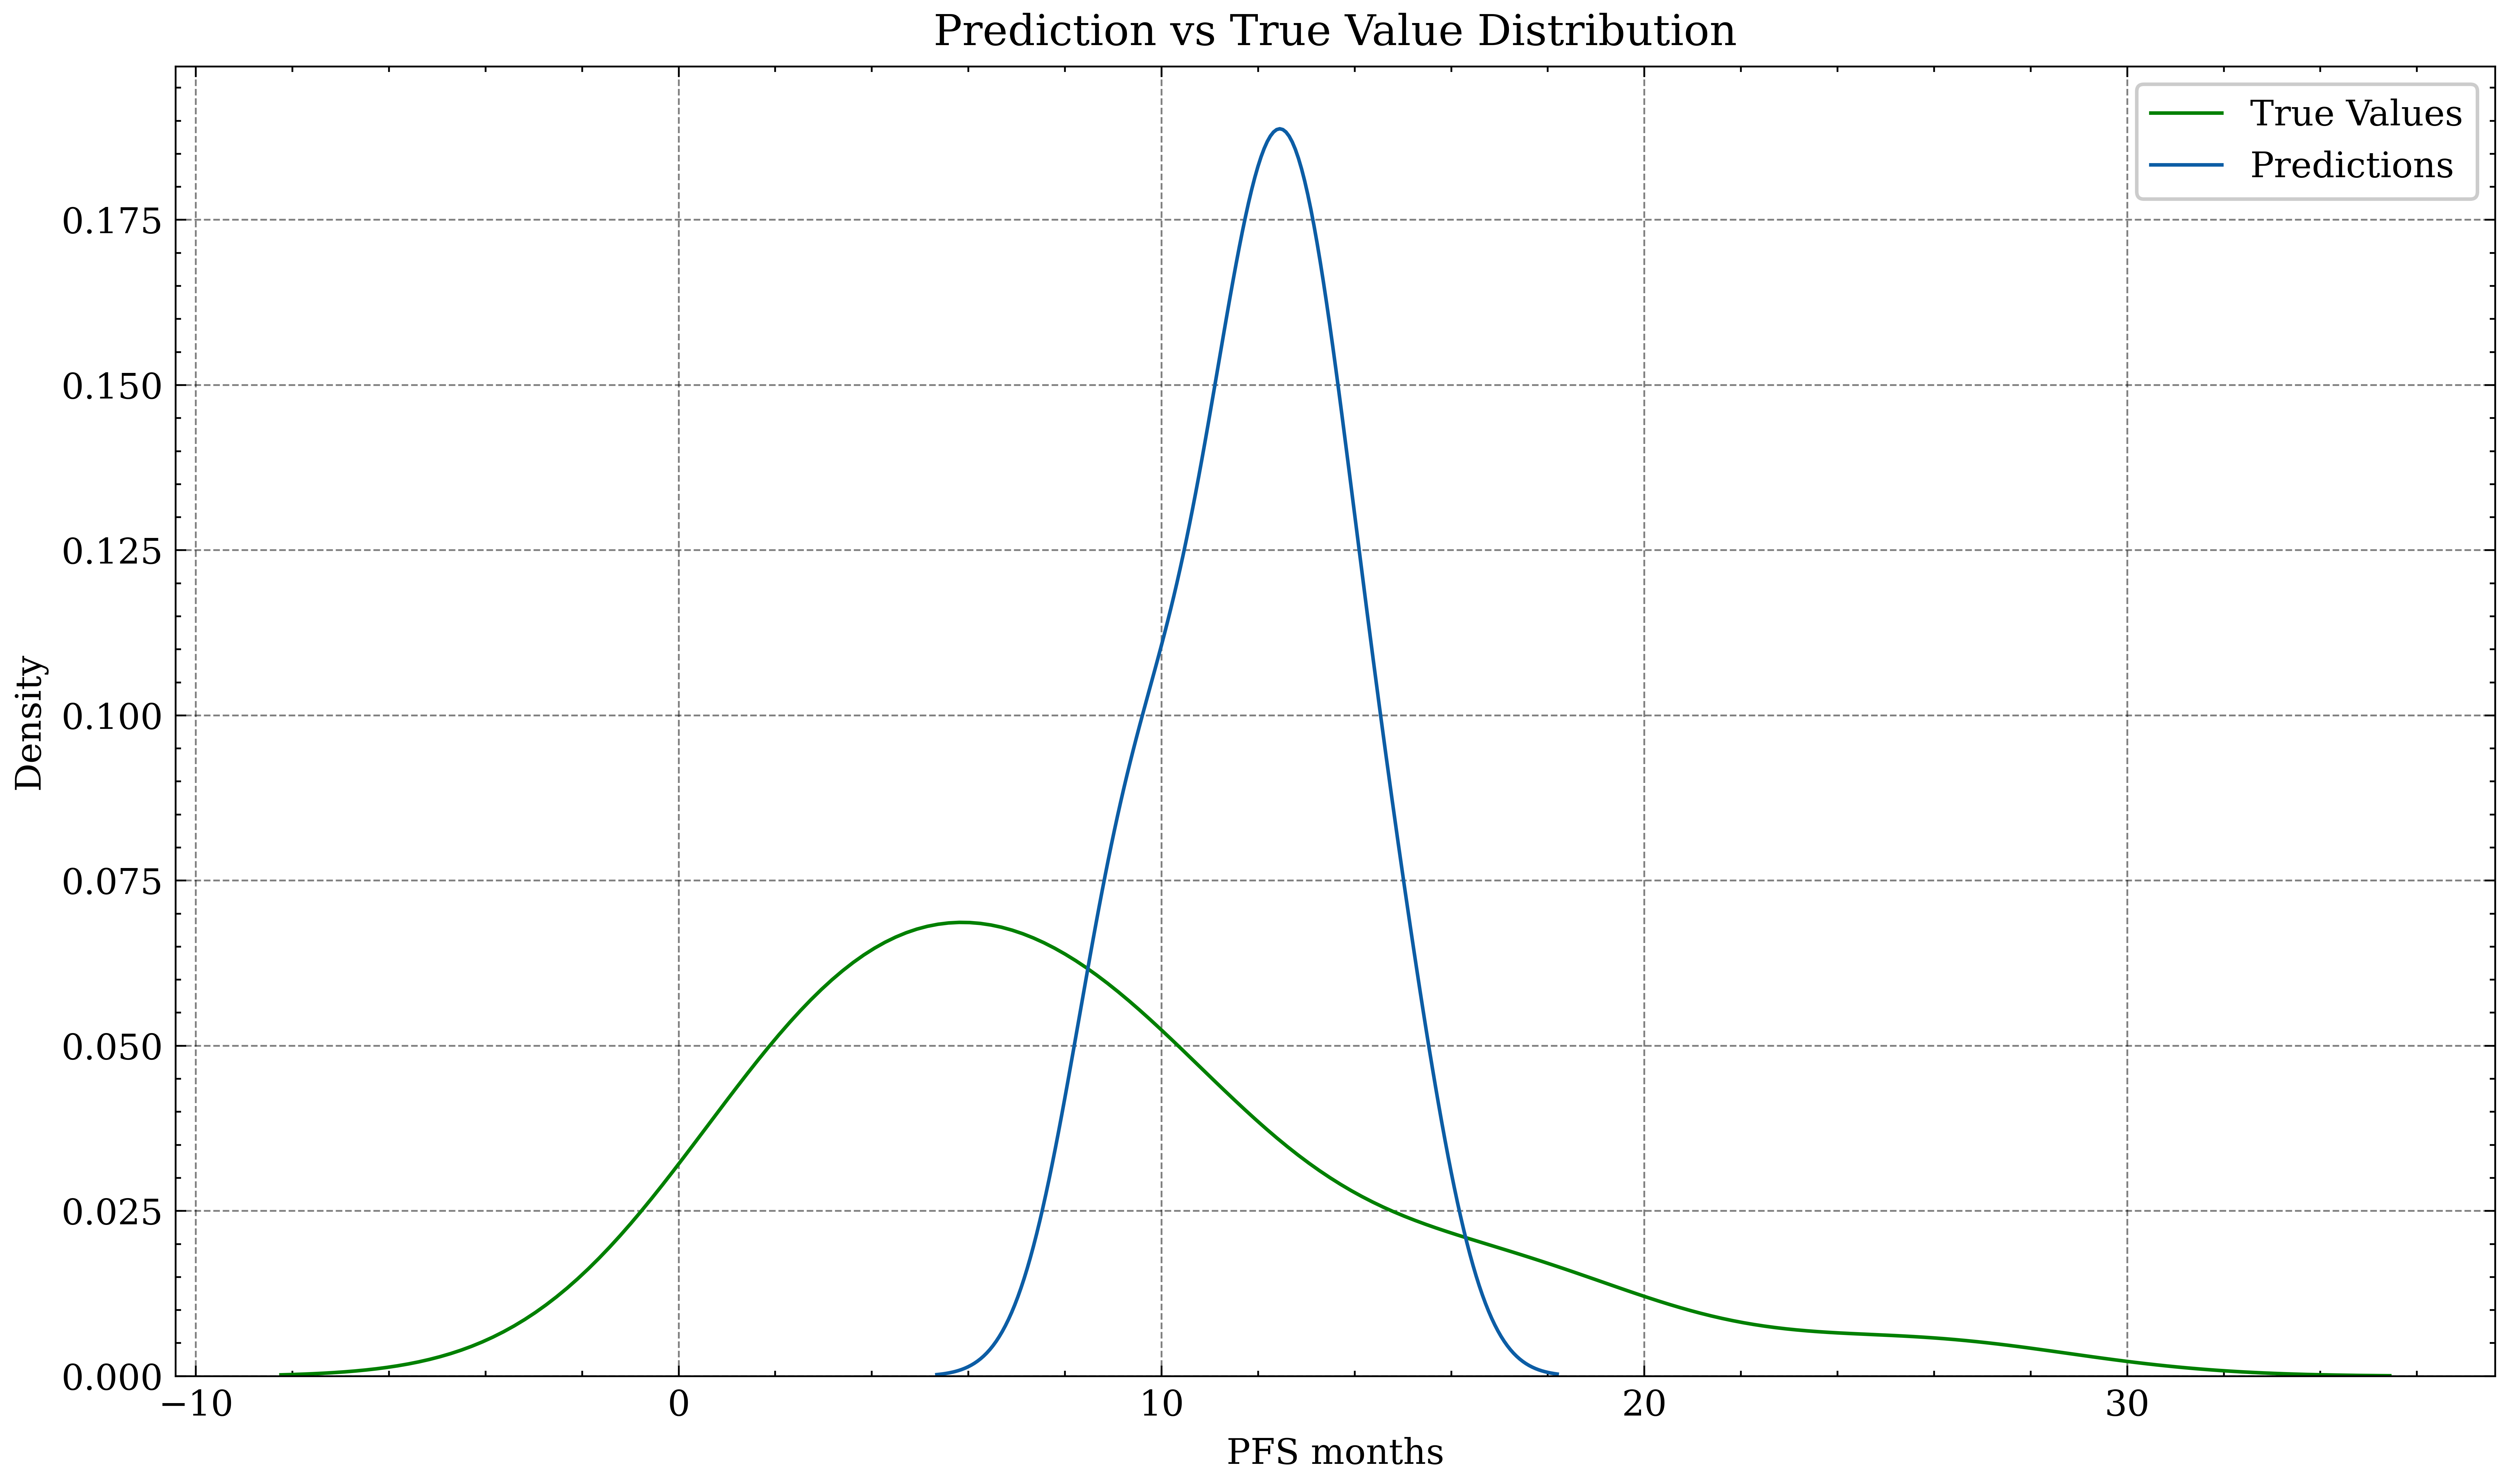

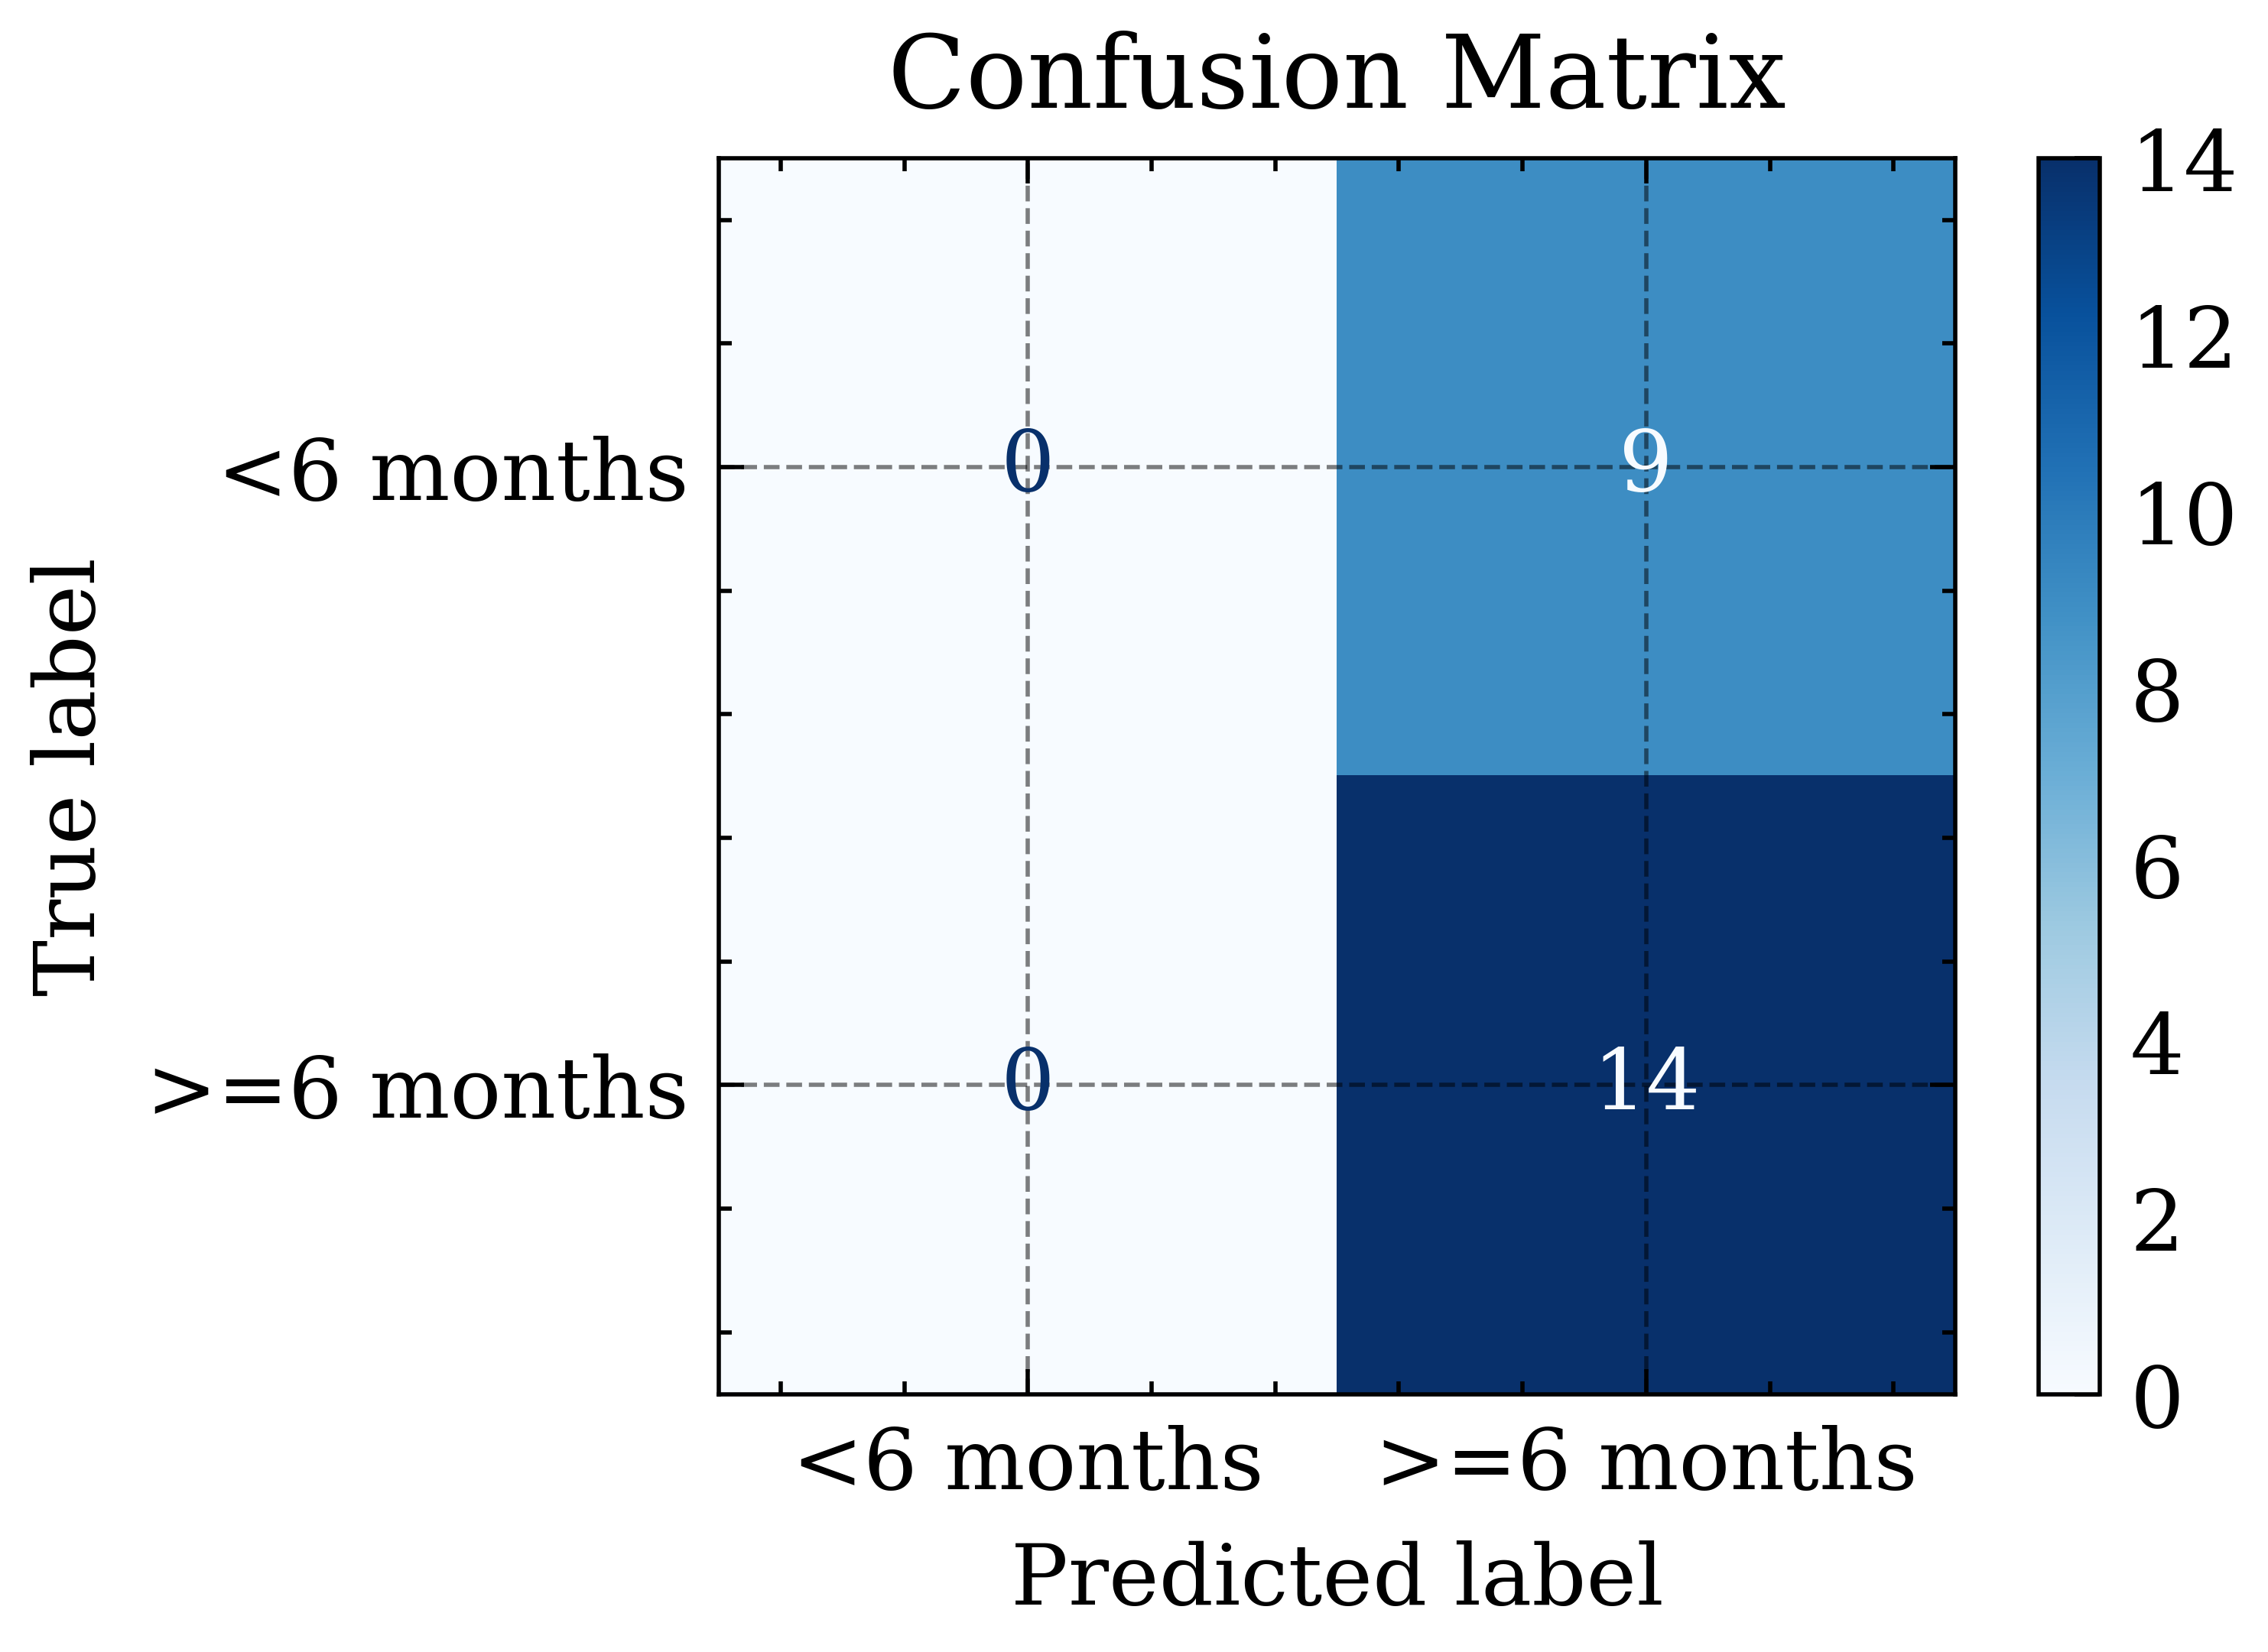

Classification report:
               precision    recall  f1-score   support

   <6 months       0.00      0.00      0.00         9
  >=6 months       0.61      1.00      0.76        14

    accuracy                           0.61        23
   macro avg       0.30      0.50      0.38        23
weighted avg       0.37      0.61      0.46        23



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [24]:
def predict_on_dataloader(model, loader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch_data in loader:
            if isinstance(batch_data, dict):
                if all(key in batch_data for key in ['image', 'clinical_features', 'pfs_months']):
                    dose_images   = batch_data['image'].to(device)
                    clinical_data = batch_data['clinical_features'].to(device)
                    labels        = batch_data['pfs_months'].to(device)
                else:
                    raise ValueError(
                        f"Expected keys ['image', 'clinical_features', 'pfs_months'] not found. "
                        f"Available keys: {list(batch_data.keys())}"
                    )
            elif isinstance(batch_data, (list, tuple)):
                if len(batch_data) >= 3:
                    dose_images   = batch_data[0].to(device)
                    clinical_data = batch_data[1].to(device)
                    labels        = batch_data[2].to(device)
                else:
                    raise ValueError("batch_data tuple does not have enough elements (expected at least 3).")
            else:
                raise ValueError("batch_data is not in an expected format")

            outputs = model(dose_images, clinical_data)
            reg_outputs = outputs[0] if isinstance(outputs, (tuple, list)) else outputs

            all_preds.append(reg_outputs.detach().cpu().numpy())
            all_labels.append(labels.detach().cpu().numpy())

    return np.concatenate(all_preds, axis=0), np.concatenate(all_labels, axis=0)


# --- Prediction Code ---
# If you have trained and have a best_model_result available, define best_result accordingly.
if 'best_model_result' in globals() and best_model_result is not None:
    best_result = {
        'Best Model Path': best_tuned_model_path,  # from training cell
        'Model Class': global_best_model_class      # from training cell
    }
else:
    best_result = None

train_flag = best_result is not None

if train_flag:
    # Use the model and model class from best_result
    pretrained_model_path = best_result['Best Model Path']
    pretrained_model_class = best_result['Model Class']
else:
    # Fallback model path and class if you have not trained or best_result is not defined
    pretrained_model_path = f'{SAVE_PATH}best_CNNVIT_PFS.pth'
    pretrained_model_class = 'CNNViT'

print(f"Using model path: {pretrained_model_path}")
print(f"Using model class: {pretrained_model_class}")

# Initialize the model based on the model class
try:
    if pretrained_model_class == 'CNNViT':
        model = cnn_vit_model(clinical_dim=clinical_dim)
    elif pretrained_model_class == 'SimpleCNN':
        model = simple_cnn_model(clinical_dim=clinical_dim)
    elif pretrained_model_class == 'DepthwiseSeparableCNN':
        model = depthwise_separable_3dcnn_model(clinical_dim=clinical_dim)
    elif pretrained_model_class == 'ChannelSeparatedCNN':
        model = channel_separated_cnn_model(clinical_dim=clinical_dim)
    else:
        raise ValueError(f"Unknown model class: {pretrained_model_class}")

    print(f"Initializing model: {pretrained_model_class}")
except ValueError as e:
    print(e)
    raise

# Load saved parameters into the model
try:
    model.load_state_dict(torch.load(pretrained_model_path, map_location=device))
    print(f"Loaded trained model from {pretrained_model_path}")
except Exception as e:
    print(f"Could not load the model: {e}")
    raise e

model.to(device)
model.eval()

# Execute prediction on the test dataset
predictions, true_labels = predict_on_dataloader(model, test_loader, device)
print("Number of NaN in predictions:", np.isnan(predictions).sum())
print("Number of NaN in true_labels:", np.isnan(true_labels).sum())

# Ensure predictions and true_labels are NumPy arrays
predictions = np.array(predictions)
true_labels = np.array(true_labels)

# Binarize predictions and true values based on a threshold of 6 months
threshold = 6.0
predicted_classes = (predictions >= threshold).astype(int)  # 1 for >= 6 months, 0 otherwise
true_classes = (true_labels >= threshold).astype(int)

# Calculate accuracy
accuracy_val = accuracy_score(true_classes, predicted_classes)
print(f"Accuracy: {accuracy_val:.4f}")

# Calculate Mean Squared Error (MSE) on test data
mse_value = mean_squared_error(true_labels, predictions)
mae_value = mean_absolute_error(true_labels, predictions)
print(f"MSE on test data: {mse_value:.4f}")
print(f"MAE on test data: {mae_value:.4f}")

plt.figure(figsize=(10, 6))
sns.kdeplot(true_labels, label='True Values', color='green')
sns.kdeplot(predictions, label='Predictions')
plt.title('Prediction vs True Value Distribution')
plt.xlabel('PFS months')
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(SAVE_PATH, 'prediction_vs_true_value_distribution.pdf'))
plt.show()

# Create and display confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix,
                              display_labels=["<6 months", ">=6 months"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.savefig(os.path.join(SAVE_PATH, 'confusion_matrix_pfs_6mnths.pdf'))
plt.show()

# Display classification report
report = classification_report(true_classes, predicted_classes,
                               target_names=["<6 months", ">=6 months"])
print("Classification report:\n", report)

In [25]:
from sklearn.metrics import r2_score

# Calculate R2 score on test data
r2 = r2_score(true_labels, predictions)
print(f"R2 score on test data: {r2:.4f}")

R2 score on test data: -0.3653


In [ ]:
# Binarize predictions and true values based on a threshold of 9 months
threshold = 9.0
predicted_classes = (predictions >= threshold).astype(int)  # 1 for >= 9 months, 0 otherwise
true_classes = (true_labels >= threshold).astype(int)

accuracy = accuracy_score(true_classes, predicted_classes)
print(f"Accuracy: {accuracy:.4f}")

# Create the confusion matrix and display it
conf_matrix = confusion_matrix(true_classes, predicted_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=["<9 months", ">=9 months"])

disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion matrix")
plt.savefig(os.path.join(SAVE_PATH, 'confusion_matrix_pfs_9mnths.pdf'))

# Print the classification report
report = classification_report(true_classes, predicted_classes, target_names=["<9 months", ">=9 months"])
print("Classification report:\n", report)

In [ ]:
# Binarize predictions and true values based on a threshold of 12 months
threshold = 12.0
predicted_classes = (predictions >= threshold).astype(int)  # 1 for >= 12 months, 0 otherwise
true_classes = (true_labels >= threshold).astype(int)

# Calculate accuracy
accuracy = accuracy_score(true_classes, predicted_classes)
print(f"Accuracy: {accuracy:.4f}")

# Create the confusion matrix and display it
conf_matrix = confusion_matrix(true_classes, predicted_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=["<12 months", ">=12 months"])

disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion matrix")
plt.savefig(os.path.join(SAVE_PATH, 'confusion_matrix_pfs_12mnths.pdf'))

report = classification_report(true_classes, predicted_classes, target_names=["<12 months", ">=12 months"])
print("Classification report:\n", report)

In [ ]:
c_index = concordance_index(true_labels, predictions)
print(f"C-index on test data: {c_index:.4f}")


In [ ]:
predictions, true_labels = predict_on_dataloader(model, test_loader, device)

print("Continuous Predictions:\n", predictions)

predictions = predictions.astype(np.float32)
# Adjust bins to include negative values
bins = [-np.inf, 6, 9, 12, np.inf]
labels = [r'$<6$', r'$6-9$', r'$9-12$', r'$\geq12$']

# Convert the continuous predictions into four classes using pd.cut.
y_pred_classes = pd.cut(predictions.flatten(), bins=bins, labels=labels, right=False)
print("\nFour-Class Predictions:\n", y_pred_classes)

# Convert the ground truth values into classes.
y_test_classes = pd.cut(true_labels.flatten(), bins=bins, labels=labels, right=False)

# Compute the confusion matrix using the defined labels.
cm = confusion_matrix(y_test_classes, y_pred_classes, labels=labels)

# Create output directory if it doesn't exist
os.makedirs(SAVE_PATH, exist_ok=True)

# Plot the confusion matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels, cbar=False)
plt.title('Confusion Matrix for Four-Class Predictions')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.savefig(os.path.join(SAVE_PATH, 'confusion_matrix_torch_best_model.pdf'))

# Print the classification report for the four classes
report = classification_report(y_test_classes, y_pred_classes, target_names=labels)
print("Classification Report:\n", report)


## Test C-index on test set

Using model path: /content/drive/MyDrive/best_tuned_model_c_index.pth
Using model class: CNNViT
Initializing model: CNNViT
Loaded trained model from /content/drive/MyDrive/best_tuned_model_c_index.pth


<ipython-input-19-4e9c9351c28f>:65: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=device.startswith('cuda')):


Number of NaN in predictions: 0
Number of NaN in true times: 0
Number of NaN in events: 0
Test Concordance Index (c-index): 0.6429


<ipython-input-19-4e9c9351c28f>:92: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(predictions, label='Predicted Risk (Inverted)', shade=True)


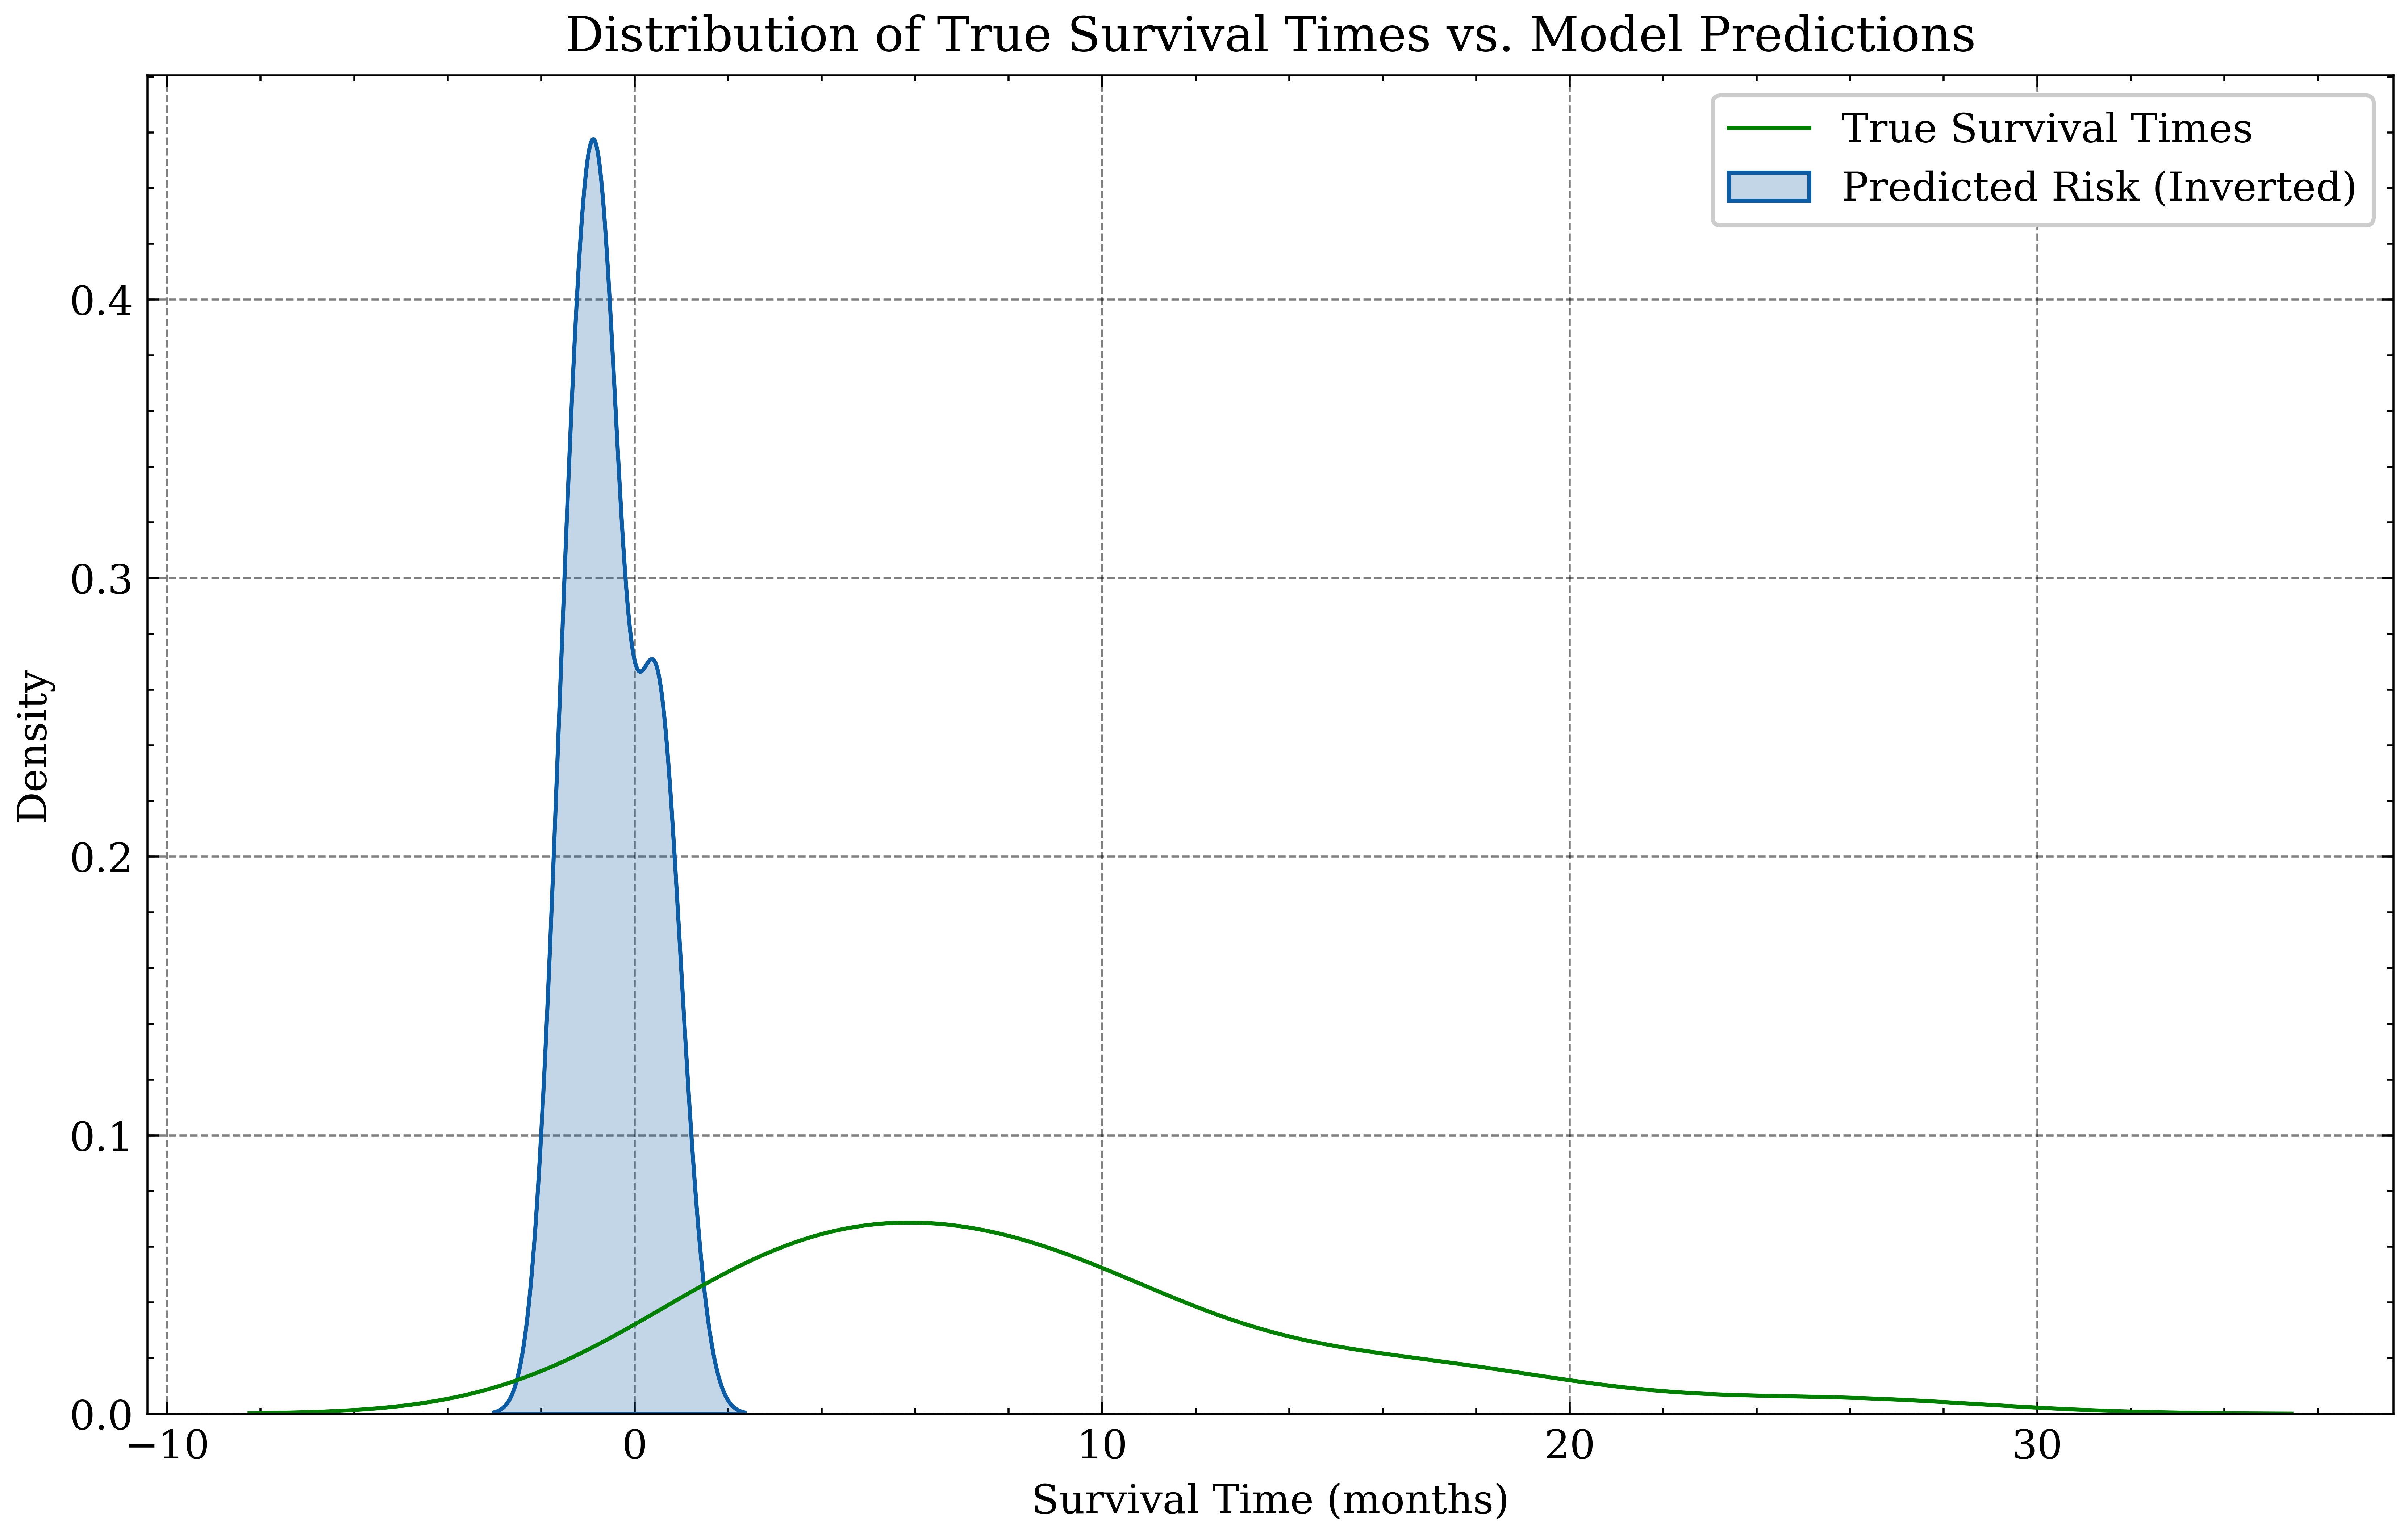

In [19]:
# --- Prediction Code for C-index ---
train_flag = False

if train_flag:
    # Use the best tuned model variables from training/tuning
    pretrained_model_path = best_tuned_model_path
    pretrained_model_class = global_best_model_class
else:
    # Fallback model path and class if not trained
    pretrained_model_path = f'{SAVE_PATH}best_tuned_model_c_index.pth'
    pretrained_model_class = 'CNNViT'

print(f"Using model path: {pretrained_model_path}")
print(f"Using model class: {pretrained_model_class}")

# Initialize the model based on the model class
try:
    if pretrained_model_class == 'CNNViT':
        model = cnn_vit_model(clinical_dim=clinical_dim)
    elif pretrained_model_class == 'SimpleCNN':
        model = simple_cnn_model(clinical_dim=clinical_dim)
    elif pretrained_model_class == 'DepthwiseSeparableCNN':
        model = depthwise_separable_3dcnn_model(clinical_dim=clinical_dim)
    elif pretrained_model_class == 'ChannelSeparatedCNN':
        model = channel_separated_cnn_model(clinical_dim=clinical_dim)
    else:
        raise ValueError(f"Unknown model class: {pretrained_model_class}")

    print(f"Initializing model: {pretrained_model_class}")
except ValueError as e:
    print(e)
    raise

# Load saved model parameters
try:
    model.load_state_dict(torch.load(pretrained_model_path, map_location=device))
    print(f"Loaded trained model from {pretrained_model_path}")
except Exception as e:
    print(f"Could not load the model: {e}")
    raise e

# Move model to device and set to evaluation mode
model.to(device)
model.eval()

# Import concordance_index if not already imported
from lifelines.utils import concordance_index

# Define a prediction function for c-index computation
def predict_for_cindex(model, data_loader, device):
    predictions = []
    true_times = []
    events = []

    model.eval()
    with torch.no_grad():
        for batch_idx, batch in enumerate(data_loader):
            # Move data to device
            pfs_months = batch['pfs_months'].float().to(device)
            pfs_event  = batch['pfs_event'].float().to(device)
            clinical_data = batch['clinical_features'].float().to(device)
            dose_images = batch['image'].to(device)

            # Use autocast for mixed precision if available
            with torch.cuda.amp.autocast(enabled=device.startswith('cuda')):
                outputs = model(dose_images, clinical_data)
            # If model outputs multiple values, assume regression output is the first element
            reg_outputs = outputs[0] if isinstance(outputs, (tuple, list)) else outputs

            # Append predictions, true survival times and events
            predictions.extend(reg_outputs.cpu().numpy().flatten())
            true_times.extend(pfs_months.cpu().numpy().flatten())
            events.extend(pfs_event.cpu().numpy().flatten())

    return np.array(predictions), np.array(true_times), np.array(events)

# Execute prediction on the test dataset
predictions, true_times, events = predict_for_cindex(model, test_loader, device)

print("Number of NaN in predictions:", np.isnan(predictions).sum())
print("Number of NaN in true times:", np.isnan(true_times).sum())
print("Number of NaN in events:", np.isnan(events).sum())

# Compute the concordance index.
# We use negative predictions because higher predicted survival times imply lower risk.
c_index = concordance_index(true_times, -predictions, events)
print(f"Test Concordance Index (c-index): {c_index:.4f}")

# Optionally, visualize the prediction distribution for survival times
plt.figure(figsize=(10, 6))
sns.kdeplot(true_times, label='True Survival Times', color='green')
sns.kdeplot(predictions, label='Predicted Risk (Inverted)', shade=True)
plt.title('Distribution of True Survival Times vs. Model Predictions')
plt.xlabel('Survival Time (months)')
plt.legend()
plt.show()